https://sensibilityit.tistory.com/511
https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895
https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html
https://blog.naver.com/PostView.nhn?blogId=reisei11&logNo=221733757476&redirect=Dlog&widgetTypeCall=true&directAccess=false

# 0. GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12637900027944006775
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6267797504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6310572336181921315
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# 1. Create Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import glob
import random
import cv2
import numpy as np

## 1.1. data path

./data/train_data
./data/sample_data  
./../../../../train_data

In [3]:
train_data_path = './data/train_data'
image_paths = glob.glob(os.path.join(train_data_path, '*'))
image_paths

['./data/train_data\\n01440764_10026.JPEG',
 './data/train_data\\n01440764_10027.JPEG',
 './data/train_data\\n01440764_10029.JPEG',
 './data/train_data\\n01440764_10040.JPEG',
 './data/train_data\\n01440764_10042.JPEG',
 './data/train_data\\n01440764_10043.JPEG',
 './data/train_data\\n01440764_10048.JPEG',
 './data/train_data\\n01440764_10066.JPEG',
 './data/train_data\\n01440764_10074.JPEG',
 './data/train_data\\n01440764_1009.JPEG',
 './data/train_data\\n01440764_10095.JPEG',
 './data/train_data\\n01440764_10108.JPEG',
 './data/train_data\\n01440764_10110.JPEG',
 './data/train_data\\n01440764_10120.JPEG',
 './data/train_data\\n01440764_10124.JPEG',
 './data/train_data\\n01440764_10150.JPEG',
 './data/train_data\\n01440764_10159.JPEG',
 './data/train_data\\n01440764_10162.JPEG',
 './data/train_data\\n01440764_10183.JPEG',
 './data/train_data\\n01440764_10194.JPEG',
 './data/train_data\\n01440764_10211.JPEG',
 './data/train_data\\n01440764_10218.JPEG',
 './data/train_data\\n01440764_10

## 1.2. train validation split 

In [4]:
def train_test_split_path(paths, split_ratio, seed=44) :
    random.seed(seed)
    random.shuffle(paths)
    train_paths, valid_paths = paths[:int(split_ratio*len(paths))], paths[int(split_ratio*len(paths)):] 
    return  train_paths, valid_paths

In [5]:
train_image_paths, valid_image_paths =  train_test_split_path(image_paths, 0.8)

In [6]:
len(train_image_paths)

1008957

In [7]:
len(valid_image_paths)

252240

## 1.3. Custom Dataset Class

In [8]:
class Custom_Image_Dataset(Dataset) :
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        img_lab_norm = img_lab.astype('float64')
        
        img_lab_norm[:, :, 0] = img_lab_norm[:, :, 0]/255
        img_lab_norm[:, :, 1] = (img_lab_norm[:, :, 1]-42)/184
        img_lab_norm[:, :, 2] = (img_lab_norm[:, :, 2]-20)/203
        
        img_l = np.expand_dims(img_lab_norm[:,:,0], axis = 2)
        img_ab = img_lab_norm[:, :, 1:]
        
        x = img_l
        y = img_ab
        
        if self.transforms is not None :
            x = self.transforms(x).float()
            y = self.transforms(y).float()
        
        return x, y

## 1.4. Data Load

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [10]:
batch_size = 32

In [11]:
train_dataset = Custom_Image_Dataset(train_image_paths, transform)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

In [12]:
valid_dataset = Custom_Image_Dataset(valid_image_paths, transform)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

In [13]:
sample_loader_train = next(iter(train_dataset))
print('x : ', sample_loader_train[0].size())
print('y : ', sample_loader_train[1].size())

x :  torch.Size([1, 128, 128])
y :  torch.Size([2, 128, 128])


In [14]:
sample_loader_train[0]

tensor([[[0.4941, 0.4863, 0.4745,  ..., 0.1020, 0.1020, 0.0941],
         [0.5373, 0.5294, 0.5176,  ..., 0.0706, 0.0745, 0.0745],
         [0.5686, 0.5608, 0.5529,  ..., 0.0588, 0.0588, 0.0588],
         ...,
         [0.7725, 0.7725, 0.7765,  ..., 0.7569, 0.7529, 0.7451],
         [0.7686, 0.7647, 0.7647,  ..., 0.7529, 0.7490, 0.7451],
         [0.7569, 0.7529, 0.7569,  ..., 0.7529, 0.7529, 0.7529]]])

In [15]:
sample_loader_train[1]

tensor([[[0.5924, 0.5924, 0.5978,  ..., 0.3967, 0.4076, 0.4185],
         [0.5870, 0.5870, 0.5870,  ..., 0.4130, 0.4239, 0.4239],
         [0.5870, 0.5870, 0.5870,  ..., 0.4348, 0.4348, 0.4348],
         ...,
         [0.5543, 0.5543, 0.5489,  ..., 0.5326, 0.5326, 0.5326],
         [0.5543, 0.5543, 0.5543,  ..., 0.5326, 0.5326, 0.5326],
         [0.5543, 0.5543, 0.5543,  ..., 0.5326, 0.5326, 0.5326]],

        [[0.7685, 0.7685, 0.7685,  ..., 0.5961, 0.5911, 0.5862],
         [0.7734, 0.7685, 0.7685,  ..., 0.5862, 0.5862, 0.5862],
         [0.7833, 0.7833, 0.7833,  ..., 0.5714, 0.5714, 0.5714],
         ...,
         [0.7882, 0.7882, 0.7882,  ..., 0.7685, 0.7685, 0.7685],
         [0.7783, 0.7783, 0.7783,  ..., 0.7685, 0.7685, 0.7685],
         [0.7833, 0.7833, 0.7833,  ..., 0.7685, 0.7685, 0.7685]]])

# 2. Define Model

In [16]:
import torch
import torch.nn as nn
from torchinfo import summary

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.1. define model function

In [18]:
class UNET(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        def conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True)
            )
            return model
        
        def max_pool() :
            model = nn.MaxPool2d(2)
            return model
        
        def up_conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_dim, out_dim, kernel_size=2, padding='same')
            )
            return model
        
        self.input = nn.Sequential()
        self.enc1 = conv(1, 64)
        self.enc2 = nn.Sequential(max_pool(), conv(64, 128))
        self.enc3 = nn.Sequential(max_pool(), conv(128, 256))
        self.enc4 = nn.Sequential(max_pool(), conv(256, 512))
        self.enc5 = nn.Sequential(max_pool(), conv(512, 1024))
        
        self.dec1 = up_conv(1024, 512)
        self.dec2 = nn.Sequential(conv(1024, 512), up_conv(512, 256))
        self.dec3 = nn.Sequential(conv(512, 256), up_conv(256, 128))
        self.dec4 = nn.Sequential(conv(256, 128), up_conv(128, 64))
        self.dec5 = conv(128, 64)
        self.out = nn.Conv2d(64, 2, kernel_size=1, padding = 'same')
        
        
        
    def forward(self, x):
        x = self.input(x)
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        
        x = self.dec1(x5)
        x = torch.cat([x, x4], dim = 1)
        x = self.dec2(x)
        x = torch.cat([x, x3], dim = 1)
        x = self.dec3(x)
        x = torch.cat([x, x2], dim = 1)
        x = self.dec4(x)
        x = torch.cat([x, x1], dim = 1)
        x = self.dec5(x)
        x = self.out(x)
        
        
        return x

## 2.2. model compile

In [19]:
model_UNET = UNET().to(device)

## 2.3. model summary

In [20]:
input_shape_list = list(tuple(sample_loader_train[0].size()))
input_shape_list.insert(0, batch_size)
input_shape = tuple(input_shape_list)

In [21]:
del sample_loader_train
torch.cuda.empty_cache()

In [22]:
summary(
    model_UNET,
    input_shape
)

C:\Users\T921\anaconda3\lib\site-packages\torch\nn\modules\conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     --                        --
├─Sequential: 1-1                        [32, 1, 128, 128]         --
├─Sequential: 1-2                        [32, 64, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        640
│    └─BatchNorm2d: 2-2                  [32, 64, 128, 128]        128
│    └─ReLU: 2-3                         [32, 64, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 64, 128, 128]        36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 128, 128]        128
│    └─ReLU: 2-6                         [32, 64, 128, 128]        --
├─Sequential: 1-3                        [32, 128, 64, 64]         --
│    └─MaxPool2d: 2-7                    [32, 64, 64, 64]          --
│    └─Sequential: 2-8                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-1                  [32, 128, 64, 64]         73,856
│   

# 3. Train Model

In [23]:
import torch
import numpy as np
import time
from tqdm.notebook import tqdm

## 3.1. Early Stopping Class

In [24]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 10
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 3.2. Training Function

**criterion 설정에서**  
onehot x -> target.squeeze().long()  
onehot o -> torch.max(train_target, 1)[1]  

In [25]:
def train_model(model, 
                train_dataloader, 
                valid_dataloader, 
                criterion, 
                optimizer, 
                n_epochs=50, 
                early_stopping=None) :
    print('----------------------------------------------------------------------------------')
    print()
    start_total = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.float()
    
    # epoch당 평균 train loss
    train_loss_list = []
    # epoch당 평균 validation loss
    valid_loss_list = []    
    
    for epoch in range(1, n_epochs + 1):
        start_epoch = time.time()
        
        print(f"Epoch {epoch}/{n_epochs}")
        
        epoch_train_loss_list = []
        epoch_valid_loss_list = []
        
        
        # train
        model.train() # prep model for training
        
        train_dataloader_tqdm = tqdm(train_dataloader, desc="Training  ")
        for batch, (train_data, train_target) in enumerate(train_dataloader_tqdm, 1):
            train_data = train_data.to(device)
            train_target = train_target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()    
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            train_output = model(train_data)
            # calculate the loss
            train_loss = criterion(train_output, train_target)
            # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
            train_loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record train loss
            epoch_train_loss_list.append(train_loss.item())
            
            del train_data
            del train_target
            del train_output
            del train_loss
            torch.cuda.empty_cache()
            
            
        # validation
        model.eval() # prep model for evaluation
        
        valid_dataloader_tqdm = tqdm(valid_dataloader, desc="Validation  ")
        for valid_data , valid_target in valid_dataloader_tqdm :
            valid_data = valid_data.to(device)
            valid_target = valid_target.to(device)
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            valid_output = model(valid_data)
            # calculate the loss
            valid_loss = criterion(valid_output, valid_target)
            # record validation loss
            epoch_valid_loss_list.append(valid_loss.item())
            
            del valid_data
            del valid_target
            del valid_output
            del valid_loss
            torch.cuda.empty_cache()

        
        # print train/validation statistics
        # epoch당 평균 loss 계산
        epoch_train_loss_avg = np.average(epoch_train_loss_list)
        epoch_valid_loss_avg = np.average(epoch_valid_loss_list)
        train_loss_list.append(epoch_train_loss_avg)
        valid_loss_list.append(epoch_valid_loss_avg)
        
        
        epoch_len = len(str(n_epochs))
        time_taken = round((time.time() - start_epoch), 2)
        time_taken_min = round(time_taken/60, 2)
        print_msg = (
            # f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
            f'ETA: {time_taken}s ({time_taken_min}min)   ' +
            f'train_loss: {epoch_train_loss_avg:.5f}   ' +
            f'valid_loss: {epoch_valid_loss_avg:.5f} ')

        print(print_msg)
        
        e_path = early_stopping.path
        n_path = '.'.join(e_path.split('.')[:-1])+'_{}.{}'.format(epoch, e_path.split('.')[-1])
        torch.save(model.state_dict(), n_path)
        
        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        if early_stopping != None :
            early_stopping(epoch_valid_loss_avg, model)
            
            if early_stopping.early_stop:
                print()
                print('----------------------------------------------------------------------------------')
                print("Early stopping")
                break

            # best model이 저장되어있는 last checkpoint를 로드한다.
            model.load_state_dict(torch.load(early_stopping.path))
        print()
        print('----------------------------------------------------------------------------------')
        print()

    time_taken_total = round((time.time() - start_total), 2)
    time_taken_total_min = round(time_taken_total/60, 2)
    print(f'time_taken_total: {time_taken_total}s ({time_taken_total_min}min) ')
    
    
    return  model, train_loss_list, valid_loss_list

## 3.3. train config

In [26]:
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(
    model_UNET.parameters(), 
    lr= 0.001, 
    weight_decay=1e-7
)
early_stopping_UNET_RGB = EarlyStopping(
    patience=10, 
    verbose=True, 
    delta=0, 
    path='./data/model_saved/checkpoint_UNET_LAB.pt'
)

## 3.4. training

In [27]:
trained_model, train_loss, valid_loss = train_model(
    model = model_UNET, 
    train_dataloader = train_dataloader, 
    valid_dataloader = valid_dataloader, 
    criterion = criterion, 
    optimizer = optimizer, 
    n_epochs=100, 
    early_stopping=early_stopping_UNET_RGB
)   

----------------------------------------------------------------------------------

Epoch 1/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15195.13s (253.25min)   train_loss: 0.00538   valid_loss: 0.00520 
Validation loss decreased (inf --> 0.005197).  Saving model ...

----------------------------------------------------------------------------------

Epoch 2/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14688.82s (244.81min)   train_loss: 0.00484   valid_loss: 0.00487 
Validation loss decreased (0.005197 --> 0.004875).  Saving model ...

----------------------------------------------------------------------------------

Epoch 3/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14807.06s (246.78min)   train_loss: 0.00463   valid_loss: 0.00456 
Validation loss decreased (0.004875 --> 0.004557).  Saving model ...

----------------------------------------------------------------------------------

Epoch 4/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15251.19s (254.19min)   train_loss: 0.00448   valid_loss: 0.00458 
EarlyStopping counter: 1 out of 10

----------------------------------------------------------------------------------

Epoch 5/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15259.39s (254.32min)   train_loss: 0.00448   valid_loss: 0.00466 
EarlyStopping counter: 2 out of 10

----------------------------------------------------------------------------------

Epoch 6/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15211.02s (253.52min)   train_loss: 0.00448   valid_loss: 0.00468 
EarlyStopping counter: 3 out of 10

----------------------------------------------------------------------------------

Epoch 7/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14838.4s (247.31min)   train_loss: 0.00448   valid_loss: 0.00464 
EarlyStopping counter: 4 out of 10

----------------------------------------------------------------------------------

Epoch 8/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14741.98s (245.7min)   train_loss: 0.00448   valid_loss: 0.00454 
Validation loss decreased (0.004557 --> 0.004541).  Saving model ...

----------------------------------------------------------------------------------

Epoch 9/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14619.87s (243.66min)   train_loss: 0.00439   valid_loss: 0.00465 
EarlyStopping counter: 1 out of 10

----------------------------------------------------------------------------------

Epoch 10/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14875.68s (247.93min)   train_loss: 0.00439   valid_loss: 0.00468 
EarlyStopping counter: 2 out of 10

----------------------------------------------------------------------------------

Epoch 11/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15066.57s (251.11min)   train_loss: 0.00439   valid_loss: 0.00485 
EarlyStopping counter: 3 out of 10

----------------------------------------------------------------------------------

Epoch 12/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14636.17s (243.94min)   train_loss: 0.00439   valid_loss: 0.00513 
EarlyStopping counter: 4 out of 10

----------------------------------------------------------------------------------

Epoch 13/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15169.83s (252.83min)   train_loss: 0.00439   valid_loss: 0.00486 
EarlyStopping counter: 5 out of 10

----------------------------------------------------------------------------------

Epoch 14/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15057.48s (250.96min)   train_loss: 0.00439   valid_loss: 0.00476 
EarlyStopping counter: 6 out of 10

----------------------------------------------------------------------------------

Epoch 15/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15230.49s (253.84min)   train_loss: 0.00439   valid_loss: 0.00466 
EarlyStopping counter: 7 out of 10

----------------------------------------------------------------------------------

Epoch 16/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15306.46s (255.11min)   train_loss: 0.00440   valid_loss: 0.00464 
EarlyStopping counter: 8 out of 10

----------------------------------------------------------------------------------

Epoch 17/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 14717.5s (245.29min)   train_loss: 0.00439   valid_loss: 0.00465 
EarlyStopping counter: 9 out of 10

----------------------------------------------------------------------------------

Epoch 18/100


Training  :   0%|          | 0/31530 [00:00<?, ?it/s]

Validation  :   0%|          | 0/7883 [00:00<?, ?it/s]

ETA: 15049.7s (250.83min)   train_loss: 0.00439   valid_loss: 0.00476 
EarlyStopping counter: 10 out of 10

----------------------------------------------------------------------------------
Early stopping
time_taken_total: 269730.11s (4495.5min) 


# 4. Visualizing Train

In [28]:
import matplotlib.pyplot as plt

## 4.1. visualizing function

In [29]:
def show_train_graph_loss(train_loss, valid_loss) :
    
    plt.plot(range(1,len(train_loss)+1),train_loss, label='train_loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='valid_loss')

    # validation loss의 최저값 지점을 찾기
    minposs = valid_loss.index(min(valid_loss))+1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
#     plt.ylim(0, 0.5) # 일정한 scale
    plt.xlim(0, len(train_loss)+1) # 일정한 scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4.2. visualizing

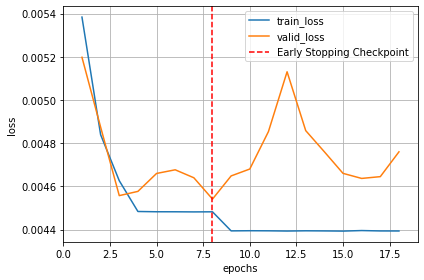

In [30]:
show_train_graph_loss(train_loss, valid_loss)